In [ ]:
# === MOUNT DRIVE ===
from google.colab import drive
drive.mount('/content/drive')

# === IMPORTS ===
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix

# === SEED FOR REPRODUCIBILITY ===
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
import os

# === Setup ===
# === CONFIG ===
BATCH_SIZE = 32
IMG_SIZE = (224, 224)   # EfficientNetB0 default is 224
DATA_DIR = "/content/drive/MyDrive/dataset_gambar"
EPOCHS = 25
AUTOTUNE = tf.data.AUTOTUNE
num_classes = 42

# === Data Augmentation ===
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),        # cast to float32 and normalize to [0,1]
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# === Preprocessing functions ===
def preprocess_and_augment_efficientnet(image, label):
    image = tf.cast(image, tf.float32)               # ensure float32
    image = data_augmentation(image)                 # apply augmentation (0–1 scale)
    image = efficientnet_preprocess(image * 255.0)   # EfficientNet expects [0,255]
    return image, label

def preprocess_only_efficientnet(image, label):
    image = tf.cast(image, tf.float32)
    image = efficientnet_preprocess(image)           # directly preprocess without aug
    return image, label

# === Load datasets ===
train_ds_eff = image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
).map(preprocess_and_augment_efficientnet, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

val_ds_eff = image_dataset_from_directory(
    os.path.join(DATA_DIR, "valid"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
).map(preprocess_only_efficientnet, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

test_ds_eff = image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
).map(preprocess_only_efficientnet, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

# === Model: EfficientNetB0 ===
base_model_eff = EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model_eff.trainable = True

# Freeze first 100 layers
for layer in base_model_eff.layers[:100]:
    layer.trainable = False

model_eff = models.Sequential([
    base_model_eff,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# === Compile ===
lr_schedule = 1e-4   # or your scheduler
optimizer_eff = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_eff.compile(
    optimizer=optimizer_eff,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === Training EfficientNetB0 ===
early_stop_eff = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint_eff = tf.keras.callbacks.ModelCheckpoint('best_model_eff.h5', save_best_only=True)

history_eff = model_eff.fit(
    train_ds_eff,
    validation_data=val_ds_eff,
    epochs=EPOCHS,
    callbacks=[early_stop_eff, checkpoint_eff]
)

# === Evaluate EfficientNetB0 ===
print("\nEvaluating EfficientNetB0 on test set:")
test_loss_eff, test_acc_eff = model_eff.evaluate(test_ds_eff)
print(f"EfficientNetB0 Test accuracy: {test_acc_eff * 100:.2f}%")


Found 8353 files belonging to 42 classes.
Found 964 files belonging to 42 classes.
Found 1001 files belonging to 42 classes.
Epoch 1/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1382 - loss: 3.4147

262/262 ━━━━━━━━━━━━━━━━━━━━ 1461s 5s/step - accuracy: 0.1387 - loss: 3.4128 - val_accuracy: 0.6535 - val_loss: 1.3603
Epoch 2/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5640 - loss: 1.5413

262/262 ━━━━━━━━━━━━━━━━━━━━ 794s 3s/step - accuracy: 0.5642 - loss: 1.5406 - val_accuracy: 0.7697 - val_loss: 0.7798
Epoch 3/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6883 - loss: 0.9911

262/262 ━━━━━━━━━━━━━━━━━━━━ 808s 3s/step - accuracy: 0.6883 - loss: 0.9909 - val_accuracy: 0.7998 - val_loss: 0.6361
Epoch 4/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7385 - loss: 0.7807

262/262 ━━━━━━━━━━━━━━━━━━━━ 846s 3s/step - accuracy: 0.7385 - loss: 0.7805 - val_accuracy: 0.8050 - val_loss: 0.5966
Epoch 5/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7754 - loss: 0.6511

262/262 ━━━━━━━━━━━━━━━━━━━━ 776s 3s/step - accuracy: 0.7754 - loss: 0.6510 - val_accuracy: 0.8143 - val_loss: 0.5408
Epoch 6/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7918 - loss: 0.5612

262/262 ━━━━━━━━━━━━━━━━━━━━ 770s 3s/step - accuracy: 0.7918 - loss: 0.5611 - val_accuracy: 0.8288 - val_loss: 0.5073
Epoch 7/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 769s 3s/step - accuracy: 0.8158 - loss: 0.4912 - val_accuracy: 0.8320 - val_loss: 0.5263
Epoch 8/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8277 - loss: 0.4400

262/262 ━━━━━━━━━━━━━━━━━━━━ 786s 3s/step - accuracy: 0.8277 - loss: 0.4400 - val_accuracy: 0.8361 - val_loss: 0.4915
Epoch 9/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 873s 3s/step - accuracy: 0.8345 - loss: 0.3965 - val_accuracy: 0.8247 - val_loss: 0.5228
Epoch 10/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8473 - loss: 0.3727

262/262 ━━━━━━━━━━━━━━━━━━━━ 893s 3s/step - accuracy: 0.8473 - loss: 0.3726 - val_accuracy: 0.8454 - val_loss: 0.4898
Epoch 11/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8653 - loss: 0.3271

262/262 ━━━━━━━━━━━━━━━━━━━━ 971s 4s/step - accuracy: 0.8653 - loss: 0.3271 - val_accuracy: 0.8465 - val_loss: 0.4840
Epoch 12/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8641 - loss: 0.3104

262/262 ━━━━━━━━━━━━━━━━━━━━ 858s 3s/step - accuracy: 0.8641 - loss: 0.3104 - val_accuracy: 0.8506 - val_loss: 0.4753
Epoch 13/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 849s 3s/step - accuracy: 0.8672 - loss: 0.2920 - val_accuracy: 0.8444 - val_loss: 0.4816
Epoch 14/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 811s 3s/step - accuracy: 0.8696 - loss: 0.2856 - val_accuracy: 0.8517 - val_loss: 0.4777
Epoch 15/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 816s 3s/step - accuracy: 0.8713 - loss: 0.2756 - val_accuracy: 0.8485 - val_loss: 0.4854
Epoch 16/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 820s 3s/step - accuracy: 0.8733 - loss: 0.2652 - val_accuracy: 0.8600 - val_loss: 0.5024
Epoch 17/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 823s 3s/step - accuracy: 0.8816 - loss: 0.2531 - val_accuracy: 0.8579 - val_loss: 0.5001
Epoch 18/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 814s 3s/step - accuracy: 0.8852 - loss: 0.2421 - val_accuracy: 0.8568 - val_loss: 0.4999
Epoch 19/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 830s 3s/step - accuracy: 0.8874 - loss: 0.2291 - val_accuracy

Detected class names: ['Ayam Crispy', 'Ayam Kecap', 'Ayam Serundeng', 'Bakso', 'Brownies', 'Bubur Ayam', 'Capcay', 'Cumi Bakar', 'Cumi Hitam', 'Cumi Rica', 'Dimsum Ikan', 'Garang Asem', 'Ikan Bakar', 'Ikan Goreng', 'Kentang Balado', 'Kue Bolu', 'Nasi Bakar', 'Nasi Goreng', 'Nasi Kuning', 'Nasi Merah', 'Nasi Rames', 'Opor Ayam', 'Pancake', 'Pecel', 'Pepes Ikan', 'Perkedel Kentang', 'Pukis', 'Rawon', 'Rendang', 'Salad Sayur', 'Sate Ayam', 'Sate Kambing', 'Sayur Asem', 'Sayur Sop', 'Soto Ayam', 'Telur Balado', 'Telur Dadar', 'Tumis Kacang Panjang Tahu', 'Tumis Kangkung', 'Tumis Terong', 'Udang Asam Manis', 'Udang Goreng Tepung']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━

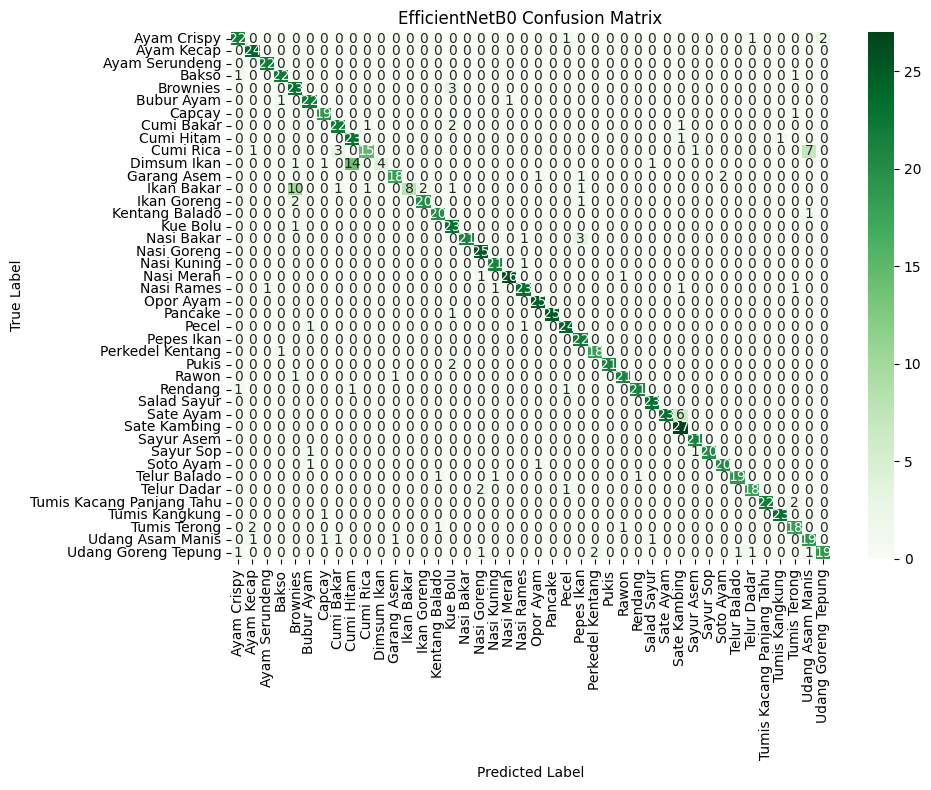

In [ ]:
class_names = sorted(os.listdir("/content/drive/MyDrive/dataset_gambar/train"))
print("Detected class names:", class_names)

# === Report ===
y_true_eff = []
y_pred_eff = []

for images, labels in test_ds_eff:
    preds = model_eff.predict(images)
    y_true_eff.extend(labels.numpy())
    y_pred_eff.extend(np.argmax(preds, axis=1))

print("\nEfficientNetB0 Classification Report:")
print(classification_report(y_true_eff, y_pred_eff, target_names=class_names))

# === CONFUSION MATRIX ===
cm_eff = confusion_matrix(y_true_eff, y_pred_eff)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_eff, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("EfficientNetB0 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()